In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

## Custom Dataset Class

We define a custom `WasteDataset` class that inherits from PyTorch's `Dataset` class. This class is responsible for loading and preprocessing the images from the dataset.

### Initialization

The `__init__` method takes the following parameters:
- `root_dir`: The root directory containing the dataset images.
- `split`: The dataset split (train, validation, or test).
- `transform`: Optional image transformations to be applied.

Inside the `__init__` method, we:
1. Store the `root_dir`, `transform`, and `split` parameters.
2. Get the list of class names by listing the directories in `root_dir`.
3. Initialize empty lists for `image_paths` and `labels`.
4. Iterate over each class directory and its subfolders ('default' and 'real_world').
5. Shuffle the image names in each subfolder.
6. Based on the `split` parameter, select a portion of the images (60% for train, 20% for validation, 20% for test).
7. Append the image paths and corresponding labels to the respective lists.

### Length and Item Retrieval

The `__len__` method returns the total number of images in the dataset.

The `__getitem__` method takes an `index` and returns the image and its corresponding label at that index. It:
1. Retrieves the image path and label using the provided index.
2. Opens the image using `Image.open()` and converts it to RGB format.
3. Applies the specified image transformations, if any.
4. Returns the transformed image and its label.

This custom dataset class allows us to easily load and preprocess the waste images for training, validation, and testing.

In [2]:
# Define the dataset class (modified to include a split parameter)
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['aluminum_soda_cans','cardboard_boxes','paper_cups','plastic_water_bottles'] #sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            image_names = os.listdir(class_dir)
            random.shuffle(image_names)
            
            if split == 'train':
                image_names = image_names[:int(0.6 * len(image_names))]
            elif split == 'val':
                image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
            else:  # split == 'test'
                image_names = image_names[int(0.8 * len(image_names)):]
            
            for image_name in image_names:
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(i)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## CNN Model Architecture

We define a convolutional neural network (CNN) model called `CNN` that inherits from PyTorch's `nn.Module` class. This model architecture consists of convolutional layers, pooling layers, and fully connected layers.

### Initialization

The `__init__` method takes the following parameter:
- `num_classes`: The number of output classes in the classification task.

Inside the `__init__` method, we define the layers of the CNN:
1. `conv1`: A 2D convolutional layer with 3 input channels, 32 output channels, a kernel size of 3, stride of 1, and padding of 1.
2. `relu`: A ReLU activation function.
3. `maxpool`: A 2D max pooling layer with a kernel size of 2 and stride of 2.
4. `conv2`: Another 2D convolutional layer with 32 input channels, 64 output channels, a kernel size of 3, stride of 1, and padding of 1.
5. `fc1`: A fully connected layer that takes the flattened output of `conv2` and maps it to 512 features.
6. `fc2`: The final fully connected layer that takes the 512 features and maps them to the number of output classes.

### Forward Pass

The `forward` method defines the forward pass of the CNN model. It takes an input tensor `x` and applies the following operations:
1. Pass `x` through `conv1`, followed by `relu` activation and `maxpool`.
2. Pass the output through `conv2`, followed by `relu` activation and `maxpool`.
3. Flatten the output of `conv2` using `x.view(x.size(0), -1)`.
4. Pass the flattened tensor through `fc1`, followed by `relu` activation.
5. Pass the output of `fc1` through `fc2` to obtain the final output.

The output of the `forward` method represents the predicted class scores for each input sample.

This CNN architecture is designed to learn hierarchical features from the input images and make predictions based on those features. The convolutional layers capture local patterns, the pooling layers reduce spatial dimensions, and the fully connected layers perform the final classification.

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Dataset Path and Hyperparameters

We set the following dataset path and hyperparameters:
- `dataset_path`: The path to the directory containing the dataset images.
- `batch_size`: The number of samples per batch during training and evaluation.
- `num_epochs`: The number of epochs to train the model.
- `learning_rate`: The learning rate for the optimizer.

These hyperparameters can be adjusted based on the specific requirements and available computational resources.

In [4]:
# Set the dataset path and hyperparameters
dataset_path = 'output_images'
batch_size = 32
num_epochs = 5
learning_rate = 0.001

## Data Preprocessing and Loaders

We define a composition of image transformations using `transforms.Compose`:
1. `transforms.Resize((224, 224))`: Resizes the images to a fixed size of (224, 224) pixels.
2. `transforms.ToTensor()`: Converts the images to PyTorch tensors.
3. `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normalizes the image tensors using the specified mean and standard deviation values.

These transformations ensure that the images are preprocessed consistently before being fed into the model.

We create instances of the `WasteDataset` class for the train, validation, and test splits, passing the `dataset_path`, `split`, and `transform` parameters. This allows us to load the dataset images with the specified transformations for each split.

Finally, we create data loaders for each dataset using `DataLoader`:
- `train_dataloader`: Loads the training data in batches of size `batch_size` and shuffles the samples.
- `val_dataloader`: Loads the validation data in batches of size `batch_size` without shuffling.
- `test_dataloader`: Loads the test data in batches of size `batch_size` without shuffling.

The data loaders provide an efficient way to iterate over the dataset during training and evaluation, handling batching and shuffling as specified.

In [5]:
from PIL import Image
from rembg import remove

def rotate_and_pad_dynamic(image, angle, background_color=(0, 0, 0), min_size=400):
    # Step 1: 旋轉並展開
    # image = remove(image)
    rotated = image.rotate(angle, expand=True, fillcolor=background_color)

    # Step 2: 動態計算正方形背景尺寸（取最大邊長，與 min_size 比較）
    side = max(min_size, rotated.width, rotated.height)
    
    # Step 3: 建立正方形背景並貼上圖片
    background = Image.new("RGB", (side, side), background_color)
    paste_x = (side - rotated.width) // 2
    paste_y = (side - rotated.height) // 2
    background.paste(rotated, (paste_x, paste_y))

    return background

In [6]:
# Create the datasets and data loaders
transform = transforms.Compose([
    transforms.Lambda(lambda img: rotate_and_pad_dynamic(img, angle=random.randint(-180, 180))),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

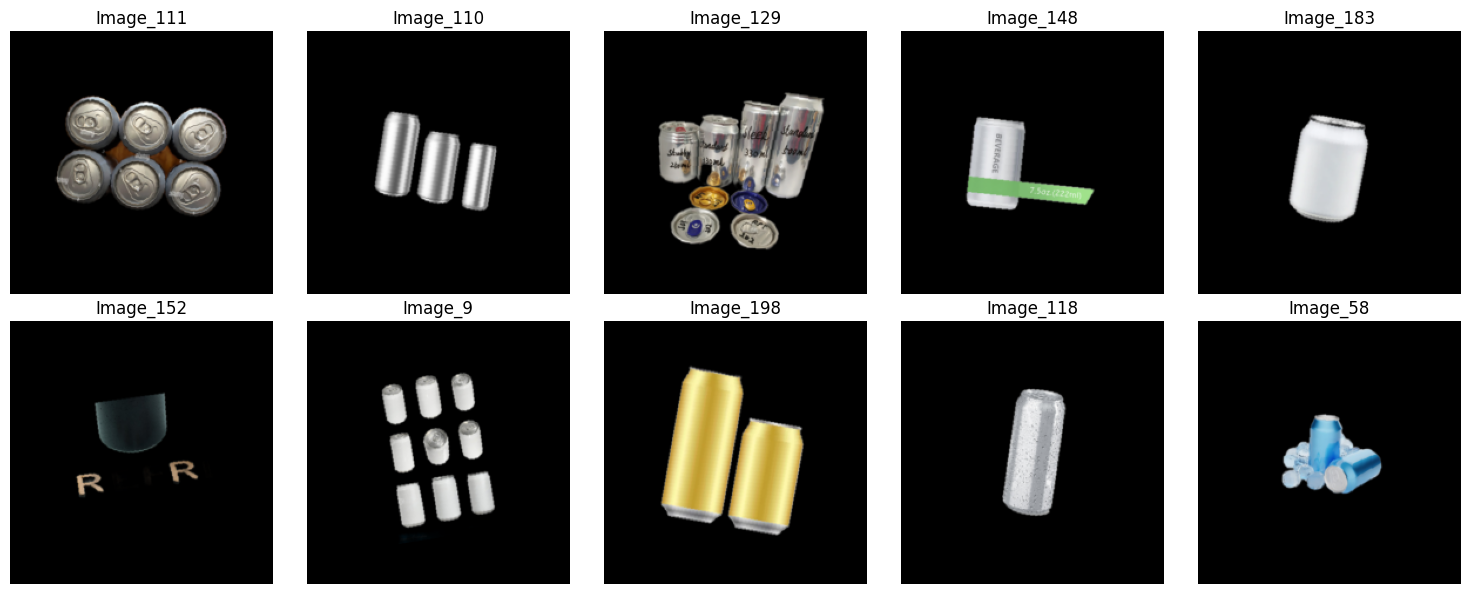

In [33]:
import numpy as np
import random
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def unnormalize(img):
    """反轉標準化，將圖片還原到可視化範圍"""
    img = img.numpy().transpose((1, 2, 0))  # 將張量轉換為 NumPy 格式
    img = std * img + mean  # 反轉標準化
    img = np.clip(img, 0, 1)  # 限制範圍在 [0, 1]
    return img

imagelist = ['aluminum_soda_cans','cardboard_boxes','paper_cups','plastic_water_bottles']

train_image_dir = os.path.join(dataset_path,imagelist[random.randint(0, len(imagelist)-1)])
imagelist = os.listdir(train_image_dir)
random.shuffle(imagelist)
# 顯示前 10 張轉換後圖片
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
count = 0

for filename in imagelist:
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(train_image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        transformed_tensor = transform(image)
        img_np = unnormalize(transformed_tensor)

        axes[count].imshow(img_np)
        axes[count].set_title(filename.split('.')[0])
        axes[count].axis('off')
        count += 1
        if count >= 10:
            break

plt.tight_layout()
plt.show()

# Model Initialization

In [21]:
# Create the model, loss function, and optimizer
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training


In [22]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Epoch [1/5], Train Loss: 2.4521, Val Loss: 1.0542
Epoch [2/5], Train Loss: 0.9638, Val Loss: 1.0368
Epoch [3/5], Train Loss: 0.8777, Val Loss: 1.0838
Epoch [4/5], Train Loss: 0.9889, Val Loss: 1.0443
Epoch [5/5], Train Loss: 0.8237, Val Loss: 1.1075
Training completed!


In [23]:
torch.save(model, 'waste_classification_model.pth')
print("Model saved successfully!")

Model saved successfully!


# 載入並測試模型

In [24]:
# # Perform sample inferences on random test images with different labels
# model.eval()
# with torch.no_grad():
#     indices = list(range(len(test_dataset)))
#     random.shuffle(indices)
    
#     selected_images = []
#     selected_labels = []
#     selected_predicted = []
    
#     for index in indices:
#         image, label = test_dataset[index]
#         image = image.unsqueeze(0).to('cuda')
        
#         output = model(image)
#         _, predicted = torch.max(output, 1)
        
#         if label not in selected_labels:
#             selected_images.append(image)
#             selected_labels.append(label)
#             selected_predicted.append(predicted.item())
        
#         if len(selected_labels) == 9:
#             break
    
#     fig, axes = plt.subplots(2, 4, figsize=(12, 12))
#     axes = axes.flatten()
    
#     for i in range(8):
#         axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
#         axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
#         axes[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

In [25]:
device = 'cuda'

model.eval()  # 切換到評估模式
correct = 0
total = 0

with torch.no_grad():  # 評估時不計算梯度
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)             # 前向推論，shape=(batch_size, num_classes)
        _, preds = torch.max(outputs, 1)    # 取每列最大值的索引作為預測

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 63.64%


In [7]:
import os
from PIL import Image
import torch
from torchvision import transforms
from rembg import remove

# 設定測試圖片資料夾
test_image_dir = 'custom_test/'

# 模型輸入所需的轉換（依照你訓練時使用的 transform）
transform = transforms.Compose([
    transforms.Lambda(lambda img: rotate_and_pad_dynamic(img, angle=random.randint(-10, 10))),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 載入你訓練好的模型
testmodel = torch.load('waste_classification_model.pth')
testmodel.eval()
testmodel.to('cuda')
# 類別標籤（順序需與訓練時相符）
class_names = train_dataset.classes

# 預測每一張圖片
for filename in os.listdir(test_image_dir):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(test_image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image = remove(image)
        input_tensor = transform(image).unsqueeze(0)  # 增加 batch dimension
        input_tensor = input_tensor.to('cuda')
        
        with torch.no_grad():
            output = testmodel(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            print(probabilities)
            predicted_class = class_names[output.argmax(1).item()]

        if predicted_class.startswith('aluminum_'):
            print(f"{filename} → 預測為: 鐵鋁罐")
        elif predicted_class.startswith('cardboard_'):
            print(f"{filename} → 預測為: 紙箱/紙板")
        elif predicted_class.startswith('plastic'):
            print(f"{filename} → 預測為: 寶特瓶")
        elif predicted_class.startswith('paper_'):
            print(f"{filename} → 預測為: 紙杯")

C:\Users\awfan\AppData\Local\Temp\ipykernel_29624\3439291188.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel = torch.load('waste_classification_model.pth')


tensor([[0.2231, 0.0025, 0.2421, 0.5323]], device='cuda:0')
image.png → 預測為: 寶特瓶
tensor([[8.9568e-02, 1.8735e-04, 7.5563e-02, 8.3468e-01]], device='cuda:0')
image1.png → 預測為: 寶特瓶
tensor([[0.0049, 0.6498, 0.3419, 0.0034]], device='cuda:0')
image2.png → 預測為: 紙箱/紙板
tensor([[0.1975, 0.0054, 0.6700, 0.1270]], device='cuda:0')
image3.png → 預測為: 紙杯
tensor([[0.1336, 0.0924, 0.6143, 0.1598]], device='cuda:0')
IMG_5157.JPG → 預測為: 紙杯
